In [1]:
import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display
from tensorflow.keras.layers   import Dense , Activation , InputLayer , Flatten , Input, BatchNormalization, Dropout, Embedding
from keras.callbacks import *

In [2]:
dir_ = Path('final_pjt/')
filepaths = list(dir_.glob(r'**/*'))
def proc_img(filepath):
    """
   		이미지데이터의 경로와 label데이터로 데이터프레임 만들기 
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # 경로와 라벨 concatenate
    df = pd.concat([filepath, labels], axis=1)

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    
    return df

df = proc_img(filepaths)
df.head(5)

,Filepath,Label
0,final_pjt/good/ediya_571_good.jpg,good
1,final_pjt/bad/ediya_522_bad.jpg,bad
2,final_pjt/good/twosome place_537_good.jpg,good
3,final_pjt/bad/ediya_596_bad.jpg,bad
4,final_pjt/good/twosome place_698_good.jpg,good


In [3]:
spac = df[df['Label'].str.contains('final_pjt')].index

df.drop(spac, inplace=True)

In [4]:
print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

Number of pictures: 4212

Number of different labels: 2

Labels: ['good' 'bad']


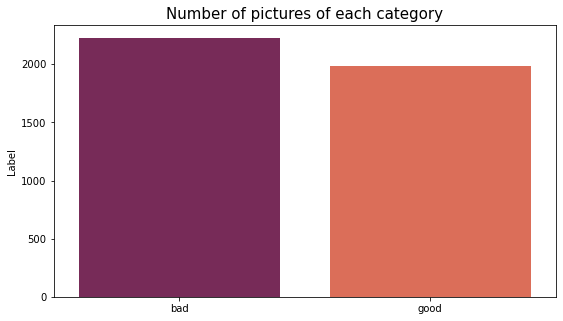

In [5]:
vc = df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

In [6]:
# Training/test split
train_df,test_df = train_test_split(df.sample(frac=0.2), test_size=0.1,random_state=0) #모델링 시간이 오래걸리면 사용
# train_df,test_df = train_test_split(df, test_size=0.1,random_state=0)
train_df.shape,test_df.shape

((757, 2), (85, 2))

In [7]:
import numpy as np
import tensorflow as tf


from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split=0.2)

train_gen = train_datagen.flow_from_directory('./final_pjt',
                                                 target_size = (300, 300),
                                                 batch_size = 16,
                                                 class_mode = 'categorical',subset='training')
val_gen  = train_datagen.flow_from_directory('./final_pjt',
                                                 target_size = (300, 300),
                                                 batch_size = 16,
                                                 class_mode = 'categorical',subset='validation')

Found 3369 images belonging to 2 classes.
Found 842 images belonging to 2 classes.


In [8]:
def create_gen():
    # 생성기 및 데이터 증강으로 이미지 로드
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath', # 파일위치 열이름
        y_col='Label', # 클래스 열이름
        target_size=(448, 448), # 이미지 사이즈
        color_mode='rgb', # 이미지 채널수
        class_mode='categorical', # Y값(Label값)
        batch_size=32,
        shuffle=True, # 데이터를 섞을지 여부
        seed=0,
        subset='training', # train 인지 val인지 설정
        rotation_range=30, # 회전제한 각도 30도
        zoom_range=0.15, # 확대 축소 15%
        width_shift_range=0.2, # 좌우이동 20%
        height_shift_range=0.2, # 상하이동 20%
        shear_range=0.15, # 반시계방햐의 각도
        horizontal_flip=True, # 좌우 반전 True
        brightness_range=(0.2,0.8),
        vertical_flip=True,
        fill_mode="nearest"
        # 이미지 변경시 보완 방법 (constant, nearest, reflect, wrap) 4개 존재
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(448, 448),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        brightness_range=(0.2,0.8),
        shear_range=0.15,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(448, 448),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

In [11]:
models = {
#     "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
#     "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
#     "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
#     "EfficientNetB0": {"model":tf.keras.applications.EfficientNetB0, "perf":0},
#     "EfficientNetB1": {"model":tf.keras.applications.EfficientNetB1, "perf":0},
#     "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
#     "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
#     "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
#     "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
#     "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
#     "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
#     "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0},
#     "ResNet152": {"model":tf.keras.applications.ResNet152, "perf":0},
}
# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(448, 448, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False # 레이어를 동결 시켜서 훈련중 손실을 최소화 한다.
    
    inputs = pretrained_model.input
    x = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)
#     x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    
#     # Step 1 - Convolution
# cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[448, 448, 3]))

# # Step 2 - Pooling
# cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
    outputs = tf.keras.layers.Dense(2, activation='sigmoid')(x)
    # 라벨 개수가 8개이기 때문에 Dencs도 8로 설정
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model


Found 682 validated image filenames belonging to 2 classes.
Found 75 validated image filenames belonging to 2 classes.
Found 85 validated image filenames belonging to 2 classes.




In [18]:
# Source code: https://github.com/opconty/keras-shufflenetV2/blob/master/shufflenetv2.py



from keras.utils.vis_utils import plot_model
from keras_applications.imagenet_utils import _obtain_input_shape
# from keras.engine.topology import get_source_inputs
from keras.utils.layer_utils import get_source_inputs
from keras.layers import Input, Conv2D, MaxPool2D, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Dense
from keras.models import Model
import keras.backend as K



import os
from keras import backend as K
from keras.models import Model
# from keras.engine.topology import get_source_inputs
from keras.layers import Activation, Add, Concatenate, Conv2D, GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D,Input, Dense
from keras.layers import MaxPool2D,AveragePooling2D, BatchNormalization, Lambda, DepthwiseConv2D
import numpy as np


def channel_split(x, name=''):
    # equipartition
    in_channles = x.shape.as_list()[-1]
    ip = in_channles // 2
    c_hat = Lambda(lambda z: z[:, :, :, 0:ip], name='%s/sp%d_slice' % (name, 0))(x)
    c = Lambda(lambda z: z[:, :, :, ip:], name='%s/sp%d_slice' % (name, 1))(x)
    return c_hat, c

def channel_shuffle(x):
    height, width, channels = x.shape.as_list()[1:]
    channels_per_split = channels // 2
    x = K.reshape(x, [-1, height, width, 2, channels_per_split])
    x = K.permute_dimensions(x, (0,1,2,4,3))
    x = K.reshape(x, [-1, height, width, channels])
    return x


def shuffle_unit(inputs, out_channels, bottleneck_ratio,strides=2,stage=1,block=1):
    if K.image_data_format() == 'channels_last':
        bn_axis = -1
    else:
        raise ValueError('Only channels last supported')

    prefix = 'stage{}/block{}'.format(stage, block)
    bottleneck_channels = int(out_channels * bottleneck_ratio)
    if strides < 2:
        c_hat, c = channel_split(inputs, '{}/spl'.format(prefix))
        inputs = c

    x = Conv2D(bottleneck_channels, kernel_size=(1,1), strides=1, padding='same', name='{}/1x1conv_1'.format(prefix))(inputs)
    x = BatchNormalization(axis=bn_axis, name='{}/bn_1x1conv_1'.format(prefix))(x)
    x = Activation('relu', name='{}/relu_1x1conv_1'.format(prefix))(x)
    x = DepthwiseConv2D(kernel_size=3, strides=strides, padding='same', name='{}/3x3dwconv'.format(prefix))(x)
    x = BatchNormalization(axis=bn_axis, name='{}/bn_3x3dwconv'.format(prefix))(x)
    x = Conv2D(bottleneck_channels, kernel_size=1,strides=1,padding='same', name='{}/1x1conv_2'.format(prefix))(x)
    x = BatchNormalization(axis=bn_axis, name='{}/bn_1x1conv_2'.format(prefix))(x)
    x = Activation('relu', name='{}/relu_1x1conv_2'.format(prefix))(x)

    if strides < 2:
        ret = Concatenate(axis=bn_axis, name='{}/concat_1'.format(prefix))([x, c_hat])
    else:
        s2 = DepthwiseConv2D(kernel_size=3, strides=2, padding='same', name='{}/3x3dwconv_2'.format(prefix))(inputs)
        s2 = BatchNormalization(axis=bn_axis, name='{}/bn_3x3dwconv_2'.format(prefix))(s2)
        s2 = Conv2D(bottleneck_channels, kernel_size=1,strides=1,padding='same', name='{}/1x1_conv_3'.format(prefix))(s2)
        s2 = BatchNormalization(axis=bn_axis, name='{}/bn_1x1conv_3'.format(prefix))(s2)
        s2 = Activation('relu', name='{}/relu_1x1conv_3'.format(prefix))(s2)
        ret = Concatenate(axis=bn_axis, name='{}/concat_2'.format(prefix))([x, s2])

    ret = Lambda(channel_shuffle, name='{}/channel_shuffle'.format(prefix))(ret)

    return ret


def block(x, channel_map, bottleneck_ratio, repeat=1, stage=1):
    x = shuffle_unit(x, out_channels=channel_map[stage-1],
                      strides=2,bottleneck_ratio=bottleneck_ratio,stage=stage,block=1)

    for i in range(1, repeat+1):
        x = shuffle_unit(x, out_channels=channel_map[stage-1],strides=1,
                          bottleneck_ratio=bottleneck_ratio,stage=stage, block=(1+i))

    return x


def ShuffleNetV2(include_top=True,
                 input_tensor=None,
                 scale_factor=1.0,
                 pooling='max',
                 input_shape=(448,448,3),
                 load_model=None,
                 num_shuffle_units=[3,7,3],
                 bottleneck_ratio=1,
                 classes=2):
    if K.backend() != 'tensorflow':
        raise RuntimeError('Only tensorflow supported for now')
    name = 'ShuffleNetV2_{}_{}_{}'.format(scale_factor, bottleneck_ratio, "".join([str(x) for x in num_shuffle_units]))
    input_shape = _obtain_input_shape(input_shape, default_size=224, min_size=28, require_flatten=include_top,
                                      data_format=K.image_data_format())
    out_dim_stage_two = {0.5:48, 1:116, 1.5:176, 2:244}

    if pooling not in ['max', 'avg']:
        raise ValueError('Invalid value for pooling')
    if not (float(scale_factor)*4).is_integer():
        raise ValueError('Invalid value for scale_factor, should be x over 4')
    exp = np.insert(np.arange(len(num_shuffle_units), dtype=np.float32), 0, 0)  # [0., 0., 1., 2.]
    out_channels_in_stage = 2**exp
    out_channels_in_stage *= out_dim_stage_two[bottleneck_ratio]  #  calculate output channels for each stage
    out_channels_in_stage[0] = 24  # first stage has always 24 output channels
    out_channels_in_stage *= scale_factor
    out_channels_in_stage = out_channels_in_stage.astype(int)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    # create shufflenet architecture
    x = Conv2D(filters=out_channels_in_stage[0], kernel_size=(3, 3), padding='same', use_bias=False, strides=(2, 2),
               activation='relu', name='conv1')(img_input)
    x = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same', name='maxpool1')(x)

    # create stages containing shufflenet units beginning at stage 2
    for stage in range(len(num_shuffle_units)):
        repeat = num_shuffle_units[stage]
        x = block(x, out_channels_in_stage,
                   repeat=repeat,
                   bottleneck_ratio=bottleneck_ratio,
                   stage=stage + 2)

    if bottleneck_ratio < 2:
        k = 1024
    else:
        k = 2048
    x = Conv2D(k, kernel_size=1, padding='same', strides=1, name='1x1conv5_out', activation='relu')(x)

    if pooling == 'avg':
        x = GlobalAveragePooling2D(name='global_avg_pool')(x)
    elif pooling == 'max':
        x = GlobalMaxPooling2D(name='global_max_pool')(x)

    if include_top:
        x = Dense(classes, name='fc')(x)
        x = Activation('sigmoid', name='sigmoid')(x)

    if input_tensor:
        inputs = get_source_inputs(input_tensor)

    else:
        inputs = img_input

    model = Model(inputs, x, name=name)

    if load_model:
        model.load_weights('', by_name=True)

    return model

In [12]:
for name, model in models.items():
    
    # 전이 학습 모델 가져오기
    m = get_model(model['model'])
    models[name]['model'] = m
    
    start = perf_counter()
    
    # 모델 학습
    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=0)
    
    # 학습시간과 val_accuracy 저장
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

Metal device set to: Apple M1 Pro


2022-06-27 09:06:39.266107: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-27 09:06:39.266271: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-06-27 09:06:42.279018: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-27 09:06:43.644928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-27 09:07:30.666738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


MobileNetV3Large     trained in 55.71 sec


2022-06-27 09:07:39.921109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-27 09:08:28.250635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Xception             trained in 56.99 sec


In [13]:
spac = test_df[test_df['Label'].str.contains('final_pjt')].index
test_df2 = test_df.drop(spac)

In [14]:
# test데이터로 모델 성능 예측
for name, model in models.items():
    
    # Predict the label of the test_images
    pred = models[name]['model'].predict(test_images)
    pred = np.argmax(pred,axis=1)

    # Map the label
    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    y_test = list(test_df2.Label)
    acc = accuracy_score(y_test,pred)
    models[name]['acc'] = round(acc,4)
    print(f'**{name} has a {acc * 100:.2f}% accuracy on the test set**')
   
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1], 
                          models[name]['acc'],
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','val_accuracy','accuracy','Training time (sec)'])
df_results.sort_values(by='accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

2022-06-27 09:08:36.018175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


**MobileNetV3Large has a 47.06% accuracy on the test set**


2022-06-27 09:08:45.368729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


**Xception has a 90.59% accuracy on the test set**


,model,val_accuracy,accuracy,Training time (sec)
0,Xception,0.9467,0.9059,56.99
1,MobileNetV3Large,0.4933,0.4706,55.71


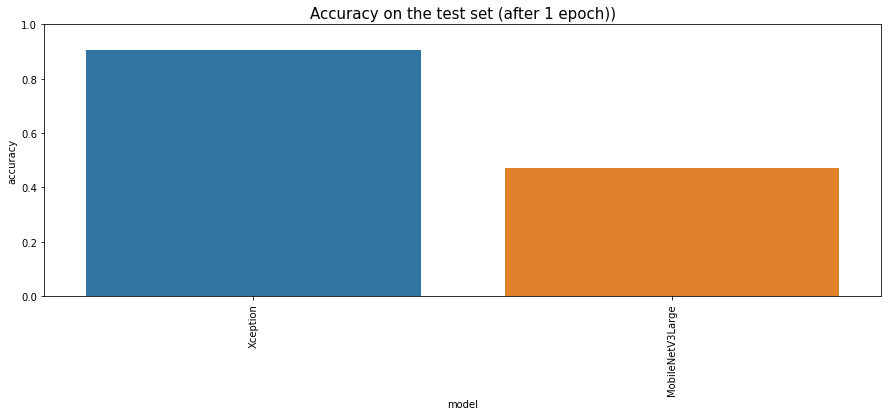

In [15]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'accuracy', data = df_results)
plt.title('Accuracy on the test set (after 1 epoch))', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

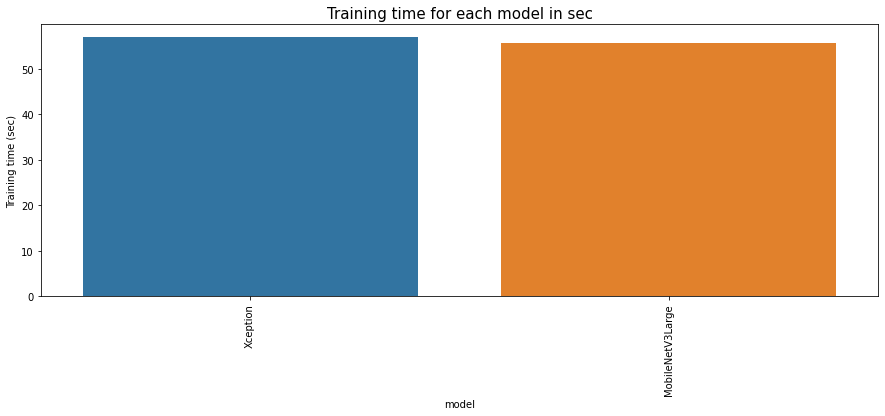

In [16]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'Training time (sec)', data = df_results)
plt.title('Training time for each model in sec', fontsize = 15)
# plt.ylim(0,20)
plt.xticks(rotation=90)
plt.show()


In [22]:
model = ShuffleNetV2(include_top=True, input_shape=(448, 448, 3),load_model=None)
model.compile(loss='binary_crossentropy', 
              optimizer='adam',   
              metrics=['accuracy'])
print(model.summary())

Model: "ShuffleNetV2_1.0_1_373"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 448, 448, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 224, 224, 24  648         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 maxpool1 (MaxPooling2D)        (None, 112, 112, 24  0           ['conv1[0][0]']                  
                                )                                            

 stage2/block2/relu_1x1conv_2 (  (None, 56, 56, 116)  0          ['stage2/block2/bn_1x1conv_2[0][0
 Activation)                                                     ]']                              
                                                                                                  
 stage2/block2/spl/sp0_slice (L  (None, 56, 56, 116)  0          ['stage2/block1/channel_shuffle[0
 ambda)                                                          ][0]']                           
                                                                                                  
 stage2/block2/concat_1 (Concat  (None, 56, 56, 232)  0          ['stage2/block2/relu_1x1conv_2[0]
 enate)                                                          [0]',                            
                                                                  'stage2/block2/spl/sp0_slice[0][
                                                                 0]']                             
          

 enate)                                                          [0]',                            
                                                                  'stage2/block4/spl/sp0_slice[0][
                                                                 0]']                             
                                                                                                  
 stage2/block4/channel_shuffle   (None, 56, 56, 232)  0          ['stage2/block4/concat_1[0][0]'] 
 (Lambda)                                                                                         
                                                                                                  
 stage3/block1/1x1conv_1 (Conv2  (None, 56, 56, 232)  54056      ['stage2/block4/channel_shuffle[0
 D)                                                              ][0]']                           
                                                                                                  
 stage3/bl

                                                                                                  
 stage3/block2/concat_1 (Concat  (None, 28, 28, 464)  0          ['stage3/block2/relu_1x1conv_2[0]
 enate)                                                          [0]',                            
                                                                  'stage3/block2/spl/sp0_slice[0][
                                                                 0]']                             
                                                                                                  
 stage3/block2/channel_shuffle   (None, 28, 28, 464)  0          ['stage3/block2/concat_1[0][0]'] 
 (Lambda)                                                                                         
                                                                                                  
 stage3/block3/spl/sp1_slice (L  (None, 28, 28, 232)  0          ['stage3/block2/channel_shuffle[0
 ambda)   

 (Lambda)                                                                                         
                                                                                                  
 stage3/block5/spl/sp1_slice (L  (None, 28, 28, 232)  0          ['stage3/block4/channel_shuffle[0
 ambda)                                                          ][0]']                           
                                                                                                  
 stage3/block5/1x1conv_1 (Conv2  (None, 28, 28, 232)  54056      ['stage3/block5/spl/sp1_slice[0][
 D)                                                              0]']                             
                                                                                                  
 stage3/block5/bn_1x1conv_1 (Ba  (None, 28, 28, 232)  928        ['stage3/block5/1x1conv_1[0][0]']
 tchNormalization)                                                                                
          

                                                                                                  
 stage3/block7/bn_1x1conv_1 (Ba  (None, 28, 28, 232)  928        ['stage3/block7/1x1conv_1[0][0]']
 tchNormalization)                                                                                
                                                                                                  
 stage3/block7/relu_1x1conv_1 (  (None, 28, 28, 232)  0          ['stage3/block7/bn_1x1conv_1[0][0
 Activation)                                                     ]']                              
                                                                                                  
 stage3/block7/3x3dwconv (Depth  (None, 28, 28, 232)  2320       ['stage3/block7/relu_1x1conv_1[0]
 wiseConv2D)                                                     [0]']                            
                                                                                                  
 stage3/bl

 stage4/block1/3x3dwconv_2 (Dep  (None, 14, 14, 464)  4640       ['stage3/block8/channel_shuffle[0
 thwiseConv2D)                                                   ][0]']                           
                                                                                                  
 stage4/block1/bn_3x3dwconv (Ba  (None, 14, 14, 464)  1856       ['stage4/block1/3x3dwconv[0][0]']
 tchNormalization)                                                                                
                                                                                                  
 stage4/block1/bn_3x3dwconv_2 (  (None, 14, 14, 464)  1856       ['stage4/block1/3x3dwconv_2[0][0]
 BatchNormalization)                                             ']                               
                                                                                                  
 stage4/block1/1x1conv_2 (Conv2  (None, 14, 14, 464)  215760     ['stage4/block1/bn_3x3dwconv[0][0
 D)       

 Activation)                                                     ]']                              
                                                                                                  
 stage4/block3/3x3dwconv (Depth  (None, 14, 14, 464)  4640       ['stage4/block3/relu_1x1conv_1[0]
 wiseConv2D)                                                     [0]']                            
                                                                                                  
 stage4/block3/bn_3x3dwconv (Ba  (None, 14, 14, 464)  1856       ['stage4/block3/3x3dwconv[0][0]']
 tchNormalization)                                                                                
                                                                                                  
 stage4/block3/1x1conv_2 (Conv2  (None, 14, 14, 464)  215760     ['stage4/block3/bn_3x3dwconv[0][0
 D)                                                              ]']                              
          

In [23]:
filepath="good_weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', 
                             verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [25]:
train_df,test_df = train_test_split(df, test_size=0.1, random_state=0)
train_generator,test_generator,train_images,val_images,test_images=create_gen()

# model = get_model(tf.keras.applications.Xception)
history = model.fit(train_images,validation_data=val_images,
                    epochs=15,callbacks=callbacks_list)


/Users/ichanghun/miniforge3/envs/tens2/lib/python3.9/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 1 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn(
/Users/ichanghun/miniforge3/envs/tens2/lib/python3.9/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 1 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn(


Found 3411 validated image filenames belonging to 2 classes.
Found 378 validated image filenames belonging to 2 classes.
Found 422 validated image filenames belonging to 2 classes.
Epoch 1/15
107/107 [==============================] - ETA: 0s - loss: 0.5227 - accuracy: 0.7575

2022-06-27 00:33:20.492273: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.49471, saving model to good_weights-improvement-01-0.49.hdf5
107/107 [==============================] - 254s 2s/step - loss: 0.5227 - accuracy: 0.7575 - val_loss: 0.6946 - val_accuracy: 0.4947
Epoch 2/15
107/107 [==============================] - ETA: 0s - loss: 0.3523 - accuracy: 0.8643
Epoch 2: val_accuracy improved from 0.49471 to 0.50529, saving model to good_weights-improvement-02-0.51.hdf5
107/107 [==============================] - 248s 2s/step - loss: 0.3523 - accuracy: 0.8643 - val_loss: 0.7136 - val_accuracy: 0.5053
Epoch 3/15
107/107 [==============================] - ETA: 0s - loss: 0.1657 - accuracy: 0.9367
Epoch 3: val_accuracy did not improve from 0.50529
107/107 [==============================] - 249s 2s/step - loss: 0.1657 - accuracy: 0.9367 - val_loss: 0.7219 - val_accuracy: 0.5053
Epoch 4/15
107/107 [==============================] - ETA: 0s - loss: 0.1442 - accuracy: 0.9510
Epoch 4: val_accuracy did not improve from 0.50

In [18]:
train_df,test_df = train_test_split(df, test_size=0.1, random_state=0)
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.Xception)
# history = 
history = model.fit(train_images,validation_data=val_images,epochs=10)

/Users/ichanghun/miniforge3/envs/tens2/lib/python3.9/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 1 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn(
/Users/ichanghun/miniforge3/envs/tens2/lib/python3.9/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 1 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn(


Found 3411 validated image filenames belonging to 2 classes.
Found 378 validated image filenames belonging to 2 classes.
Found 422 validated image filenames belonging to 2 classes.
Epoch 1/10


2022-06-27 09:19:35.308794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


107/107 [==============================] - ETA: 0s - loss: 0.3153 - accuracy: 0.8780

2022-06-27 09:23:27.872640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


107/107 [==============================] - 259s 2s/step - loss: 0.3153 - accuracy: 0.8780 - val_loss: 0.1815 - val_accuracy: 0.9339
Epoch 2/10
107/107 [==============================] - 250s 2s/step - loss: 0.1712 - accuracy: 0.9411 - val_loss: 0.1508 - val_accuracy: 0.9339
Epoch 3/10
107/107 [==============================] - 252s 2s/step - loss: 0.1377 - accuracy: 0.9513 - val_loss: 0.1164 - val_accuracy: 0.9603
Epoch 4/10
107/107 [==============================] - 252s 2s/step - loss: 0.1133 - accuracy: 0.9604 - val_loss: 0.1044 - val_accuracy: 0.9656
Epoch 5/10
107/107 [==============================] - 250s 2s/step - loss: 0.0988 - accuracy: 0.9645 - val_loss: 0.0917 - val_accuracy: 0.9630
Epoch 6/10
107/107 [==============================] - 251s 2s/step - loss: 0.0849 - accuracy: 0.9686 - val_loss: 0.0896 - val_accuracy: 0.9683
Epoch 7/10
107/107 [==============================] - 258s 2s/step - loss: 0.0773 - accuracy: 0.9736 - val_loss: 0.0813 - val_accuracy: 0.9656
Epoch 8/10

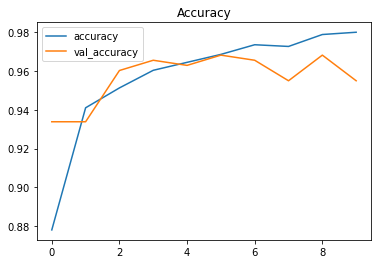

In [19]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

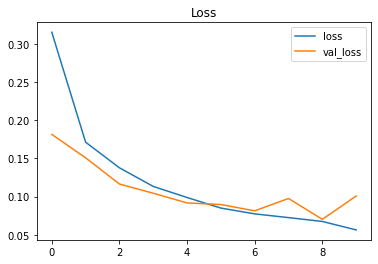

In [20]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [21]:
spac = test_df[test_df['Label'].str.contains('final_pjt')].index
test_df2 = test_df.drop(spac)

test_df2

,Filepath,Label
3683,final_pjt/bad/ediya_139_bad.jpeg,bad
2232,final_pjt/bad/ediya_130_bad.jpeg,bad
2535,final_pjt/bad/twosome place_428_bad.jpg,bad
195,final_pjt/good/ediya_102_good.jpg,good
2915,final_pjt/bad/starbucks_85_bad.JPG,bad
...,...,...
1332,final_pjt/good/starbucks_523_good.jpg,good
1010,final_pjt/bad/ediya_132_bad.jpeg,bad
1955,final_pjt/bad/twosome place_348_bad.jpg,bad
2594,final_pjt/good/starbucks_119_good.jpg,good


In [22]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]
    
y_test = list(test_df2.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

2022-06-27 10:02:00.449940: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Accuracy on the test set: 95.97%


In [23]:
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

              precision    recall  f1-score   support

         bad       1.00      0.93      0.96       218
        good       0.93      1.00      0.96       204

    accuracy                           0.96       422
   macro avg       0.96      0.96      0.96       422
weighted avg       0.96      0.96      0.96       422



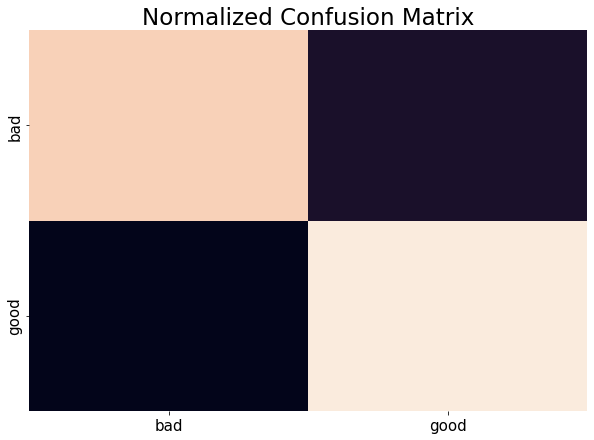

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,7))
sns.heatmap(cf_matrix, annot=False, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=False)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

번호를 입력하세요 : 7


## 예측률 : 100.00%

### Class prediction = good

[[2.4309074e-06 9.9999690e-01]]


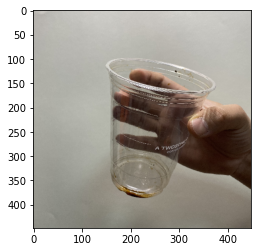

In [65]:
# from PIL import Image
import pandas as pd
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))
class_dictionary = {'bad':0,
                   'good':1}
IMAGE_SIZE    = (448, 448)
number_1 = int(input("번호를 입력하세요 : ")) # 10, 50, 100
test_image = image.load_img(test_df.iloc[number_1, 0]
                            ,target_size =IMAGE_SIZE )
test_image = image.img_to_array(test_image)
plt.imshow(test_image/255.);

test_image = test_image.reshape((1, test_image.shape[0], test_image.shape[1], test_image.shape[2]))
test_image = preprocess_input(test_image)
prediction = model.predict(test_image)

df = pd.DataFrame({'pred':prediction[0]})
df = df.sort_values(by='pred', ascending=False, na_position='first')
printmd(f"## 예측률 : {(df.iloc[0]['pred'])* 100:.2f}%")

for x in class_dictionary:
  if class_dictionary[x] == (df[df == df.iloc[0]].index[0]):
    printmd(f"### Class prediction = {x}")
    break

print(prediction)

In [22]:
# # Display picture of the dataset with their labels
# fig, axes = plt.subplots(nrows=7, ncols=4, figsize=(30, 12),
#                         subplot_kw={'xticks': [], 'yticks': []})

# for i, ax in enumerate(axes.flat):
#     ax.imshow(plt.imread(test_df2.Filepath.iloc[i]))
#     ax.set_title(f"True: {test_df2.Label.iloc[i].split('_')[0]}\nPredicted: {pred[i].split('_')[0]}", fontsize = 15)
# plt.tight_layout()
# plt.show()

In [ ]:
model.summary()

In [25]:
model.save('good_bad_xception_adam_epoch20_batch16.h5')

In [26]:
tf.saved_model.save(model, './good_bad_xception_adam_epoch20_batch16')

def representative_dataset():
    for _ in range(100):
      data = np.random.rand(1, 448, 448, 3)
      yield [data.astype(np.float32)]

converter = tf.lite.TFLiteConverter.from_saved_model('./good_bad_xception_adam_epoch20_batch16')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8  # or tf.uint8
converter.inference_output_type = tf.uint8  # or tf.uint8
tflite_quant_model = converter.convert()
open("good_bad_xception_adam_epoch20_batch16.tflite", "wb").write(tflite_quant_model)


2022-06-27 10:02:32.703754: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./good_bad_xception_adam_epoch20_batch16/assets


2022-06-27 10:02:52.945402: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-06-27 10:02:52.945420: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-06-27 10:02:52.950641: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: ./good_bad_xception_adam_epoch20_batch16
2022-06-27 10:02:52.964619: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-06-27 10:02:52.964631: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: ./good_bad_xception_adam_epoch20_batch16
2022-06-27 10:02:53.000283: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-06-27 10:02:53.281597: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: ./good_bad_xception_adam_epoch20_batch16
2022-06-27 10:02:53.360605: I tensorflow/cc/saved_model/loader.cc:30

22474800

In [27]:
hist_df = pd.DataFrame(history.history) 
hist_csv_file = 'good_bad_xception_adam_epoch20_batch16.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)